In [495]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score,accuracy_score, mean_squared_error, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import altair as alt
import seaborn as sns
import re
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
data = 'data/FURNITURE_MODEL_2024.csv'
df = pd.read_csv(data, skiprows=0, skipfooter=0, engine='python')
df.head()

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3798,AMS3132,...,AMS3994,AMS3995,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
0,10619502751261,93,01JAN2018:00:00:00,07JUN2021:00:00:00,1,0,10619502751261,20180128_PROD_EFXDataAttributes.xml,NaN,NaN,...,714.0,4286.0,1107140,2111174,0,0,0,0,0,0
1,10619502805133,93,01MAR2018:00:00:00,24JAN2022:00:00:00,0,0,10619502805133,20220128_PROD_EFXDataAttributes.xml,NaN,11.0,...,0.0,0.0,1472314,14970045,0,0,0,0,0,0
2,10619503169505,93,01MAR2019:00:00:00,03FEB2021:00:00:00,1,0,10619503169505,20190325_PROD_EFXDataAttributes.xml,NaN,NaN,...,984.0,4590.0,1213997,2990387,1,1,0,1,1,1
3,10619503474509,93,01DEC2019:00:00:00,01APR2021:00:00:00,1,0,10619503474509,20191216_PROD_EFXDataAttributes.xml,NaN,108.0,...,0.0,10000.0,1284472,5032014,0,0,0,0,0,0
4,10619503594611,93,01FEB2020:00:00:00,27JAN2021:00:00:00,0,0,10619503594611,20210128_PROD_EFXDataAttributes.xml,NaN,NaN,...,6667.0,10000.0,1388382,7708513,0,0,0,0,0,0


In [3]:
df.shape

(195467, 558)

In [4]:
df['ACCOUNT_OPEN_DATE'] = df['ACCOUNT_OPEN_DATE'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y:%H:%M:%S'))
df['APPLICATION_DATE'] = df['APPLICATION_DATE'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y:%H:%M:%S'))

In [5]:
# check data type, shape and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195467 entries, 0 to 195466
Columns: 558 entries, PROG_SOL_NUMBER to CHARGE_OFF_9M
dtypes: datetime64[ns](2), float64(538), int64(13), object(5)
memory usage: 832.1+ MB


In [6]:
train_start_date = '2021-07-01'
train_end_date = '2022-06-30'

In [7]:
df_train = df[(df['ACCOUNT_OPEN_DATE'] >= train_start_date) & (df['ACCOUNT_OPEN_DATE'] <= train_end_date)]
df_holdout = df[~(df['ACCOUNT_OPEN_DATE'] >= train_start_date) & (df['ACCOUNT_OPEN_DATE'] <= train_end_date)]

In [8]:
df_train

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3798,AMS3132,...,AMS3994,AMS3995,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
1,10619502805133,93,2018-03-01,2022-01-24,0,0,10619502805133,20220128_PROD_EFXDataAttributes.xml,NaN,11.0,...,0.0,0.0,1472314,14970045,0,0,0,0,0,0
52,10619503781960,93,2020-07-01,2021-07-11,0,0,10619503781960,20210713_PROD_EFXDataAttributes.xml,NaN,23.0,...,1429.0,4286.0,1430150,10585362,1,0,0,1,0,0
121,10619503837028,93,2020-08-01,2021-10-18,0,0,10619503837028,20211020_PROD_EFXDataAttributes.xml,NaN,NaN,...,2500.0,10000.0,1451580,12736251,0,0,0,0,0,0
139,10619503845534,93,2020-08-01,2021-07-07,0,0,10619503845534,20210708_PROD_EFXDataAttributes.xml,NaN,52.0,...,3333.0,6667.0,1429443,10469540,1,1,0,1,1,1
161,10619503856010,93,2020-08-01,2021-08-23,0,0,10619503856010,20210825_PROD_EFXDataAttributes.xml,NaN,41.0,...,0.0,0.0,1438552,11506297,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195442,13109500638048,12131,2022-06-01,2022-06-30,0,0,13109500638048,20220705_PROD_EFXDataAttributes.xml,NaN,32.0,...,3333.0,3333.0,1504688,18560690,0,0,0,0,0,0
195443,13109500638055,12131,2022-06-01,2022-06-30,0,0,13109500638055,20220709_PROD_EFXDataAttributes.xml,NaN,64.0,...,0.0,10000.0,1505553,18635900,0,0,0,0,0,0
195444,13109500638071,12131,2022-06-01,2022-06-30,0,0,13109500638071,20220702_PROD_EFXDataAttributes.xml,NaN,31.0,...,0.0,10000.0,1504035,18484134,0,0,0,1,0,0
195445,13109500638089,12131,2022-06-01,2022-06-30,0,0,13109500638089,20220712_PROD_EFXDataAttributes.xml,5973.0,NaN,...,1818.0,8182.0,1506267,18708155,0,0,0,0,0,0


In [9]:
df_holdout

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3798,AMS3132,...,AMS3994,AMS3995,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
0,10619502751261,93,2018-01-01,2021-06-07,1,0,10619502751261,20180128_PROD_EFXDataAttributes.xml,NaN,NaN,...,714.0,4286.0,1107140,2111174,0,0,0,0,0,0
2,10619503169505,93,2019-03-01,2021-02-03,1,0,10619503169505,20190325_PROD_EFXDataAttributes.xml,NaN,NaN,...,984.0,4590.0,1213997,2990387,1,1,0,1,1,1
3,10619503474509,93,2019-12-01,2021-04-01,1,0,10619503474509,20191216_PROD_EFXDataAttributes.xml,NaN,108.0,...,0.0,10000.0,1284472,5032014,0,0,0,0,0,0
4,10619503594611,93,2020-02-01,2021-01-27,0,0,10619503594611,20210128_PROD_EFXDataAttributes.xml,NaN,NaN,...,6667.0,10000.0,1388382,7708513,0,0,0,0,0,0
5,10619503611399,93,2020-03-01,2021-01-25,0,0,10619503611399,20210126_PROD_EFXDataAttributes.xml,NaN,NaN,...,0.0,5000.0,1387742,7683751,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195462,88889500501672,1800,2021-03-01,2021-03-17,0,0,88889500501672,20210317_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1400921,8105816,0,0,0,0,0,0
195463,88889500501706,1800,2021-03-01,2021-03-17,0,0,88889500501706,20210317_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1400921,8109730,0,0,0,0,0,0
195464,88889500501722,1800,2021-03-01,2021-03-18,0,0,88889500501722,20210318_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1401259,8121081,0,0,0,0,0,0
195465,88889500501748,1800,2021-03-01,2021-03-18,0,0,88889500501748,20210318_PROD_EFXDataAttributes.xml,NaN,NaN,...,NaN,NaN,1401259,8117529,0,0,0,0,0,0


In [10]:
####################  EDA  ####################

In [11]:
# check data type, shape and info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121783 entries, 1 to 195446
Columns: 558 entries, PROG_SOL_NUMBER to CHARGE_OFF_9M
dtypes: datetime64[ns](2), float64(538), int64(13), object(5)
memory usage: 519.4+ MB


In [12]:
# check missing values
df_train.isna().sum()

PROG_SOL_NUMBER       0
VENDOR_ID             0
APPLICATION_DATE      0
ACCOUNT_OPEN_DATE     0
WEB_APPS              0
                     ..
THREE_PLUS_EVER_6M    0
CHARGE_OFF_6M         0
TWO_PLUS_EVER_9M      0
THREE_PLUS_EVER_9M    0
CHARGE_OFF_9M         0
Length: 558, dtype: int64

In [396]:
# keep the column that has less than 50% of the row missing
df_train_missing=df_train.isna()
result=df_train_missing.sum()/len(df_train)

na_threshold = 0.1

df_train_new = df_train.loc[:,result < na_threshold]

In [397]:
{k:v for k,v in zip(result.index, list(result))}

{'PROG_SOL_NUMBER': 0.0,
 'VENDOR_ID': 0.0,
 'APPLICATION_DATE': 0.0,
 'ACCOUNT_OPEN_DATE': 0.0,
 'WEB_APPS': 0.0,
 'FRAUD_CHARGEOFF': 0.0,
 'PROG_SOL_NUMBER0': 0.0,
 'FILE_NAME': 0.0,
 'AMS3798': 0.7066339308442064,
 'AMS3132': 0.5699317638750893,
 'AMS3242': 0.08687583652890797,
 'AMS3909': 0.06875343849305732,
 'AMS3102': 0.008531568445513742,
 'AMS3363': 0.339242751451352,
 'AMS3195': 0.6859413875499865,
 'AMS3836': 0.04005485166238309,
 'AMS3856': 0.09652414540617328,
 'AMS3257': 0.04042436136406559,
 'AMS3387': 0.5699563978552015,
 'AMS3109': 0.008531568445513742,
 'AMS3124': 0.09534992568749333,
 'AMS3146': 0.04005485166238309,
 'CREATED_DATE': 0.0,
 'CREATED_BY': 0.0,
 'UPDATED_DATE': 0.0,
 'UPDATED_BY': 0.0,
 'AMS3000': 0.13909166303999737,
 'AMS3001': 0.13909166303999737,
 'AMS3002': 0.13909166303999737,
 'AMS3008': 0.1428031827102305,
 'AMS3009': 0.1428031827102305,
 'AMS3010': 0.1428031827102305,
 'AMS3011': 0.1428031827102305,
 'AMS3012': 0.25157041623215065,
 'AMS3013': 0

In [398]:
df_train_new.dropna(axis=0, inplace=True)

In [450]:
df_train_new

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,AMS3242,AMS3909,...,AMS3991,AMS3992,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
1,10619502805133,93,2018-03-01,2022-01-24,0,0,10619502805133,20220128_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1472314,14970045,0,0,0,0,0,0
52,10619503781960,93,2020-07-01,2021-07-11,0,0,10619503781960,20210713_PROD_EFXDataAttributes.xml,0.0,1.0,...,0.0,0.0,1430150,10585362,1,0,0,1,0,0
139,10619503845534,93,2020-08-01,2021-07-07,0,0,10619503845534,20210708_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1429443,10469540,1,1,0,1,1,1
269,10619503897287,93,2020-09-01,2021-07-25,0,0,10619503897287,20200905_PROD_EFXDataAttributes.xml,0.0,1.0,...,0.0,0.0,1350569,6557238,0,0,0,0,0,0
286,10619503900099,93,2020-09-01,2021-07-09,0,0,10619503900099,20210710_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1429629,10510934,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195441,13109500638030,12131,2022-06-01,2022-06-30,0,0,13109500638030,20220709_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,2000.0,1505553,18635861,0,0,0,0,0,0
195443,13109500638055,12131,2022-06-01,2022-06-30,0,0,13109500638055,20220709_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1505553,18635900,0,0,0,0,0,0
195444,13109500638071,12131,2022-06-01,2022-06-30,0,0,13109500638071,20220702_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1504035,18484134,0,0,0,1,0,0
195445,13109500638089,12131,2022-06-01,2022-06-30,0,0,13109500638089,20220712_PROD_EFXDataAttributes.xml,0.0,8.0,...,0.0,3214.0,1506267,18708155,0,0,0,0,0,0


In [441]:
df_train_new['VENDOR_ID'].value_counts(normalize=True)

9151     0.583753
93       0.092920
8635     0.060205
12131    0.052134
3672     0.040914
           ...   
11813    0.000012
11353    0.000012
12531    0.000012
7193     0.000012
11254    0.000012
Name: VENDOR_ID, Length: 94, dtype: float64

In [442]:
#df_train_new = df_train_new[df_train_new['VENDOR_ID']==9151]
#df_train_new

In [443]:
# record dropped attributes
df_dropped = df_train.loc[:,result >= na_threshold]
na_dropped_columns = pd.DataFrame(df_dropped.columns)
na_dropped_columns.rename(columns={0: 'original_cname'}, inplace=True)
na_dropped_columns

,original_cname
0,AMS3798
1,AMS3132
2,AMS3363
3,AMS3195
4,AMS3387
...,...
231,AMS3985
232,AMS3990
233,AMS3993
234,AMS3994


In [444]:
# map dropped attributes to its mapped meaning based on Equifax file
ams_column_mapping_path = 'data/ams_column_mapping.csv'
ams_column_mapping_df = pd.read_csv(ams_column_mapping_path, skiprows=0, skipfooter=0, engine='python')
ams_column_mapping_df = ams_column_mapping_df.merge(na_dropped_columns, on=['original_cname'])
ams_column_mapping_df

,original_cname,mapped_cname
0,AMS3000,# Inq w/in 3 M
1,AMS3001,# Inq w/in 12 M
2,AMS3002,# Inq w/in 24 M
3,AMS3008,# Non-Util Inq w/in 1 Month
4,AMS3009,# Non-Util Inq w/in 3 M
...,...,...
231,AMS3985,% Dept Store Trades w/MajDerog Event w/in 24 M...
232,AMS3990,% Dept Store Trades w/Unpaid MajDerog Event w/...
233,AMS3993,% Inq w/in 3 M to Inq w/in 12 M
234,AMS3994,% Inq w/in 3 M to Inq w/in 24 M


In [445]:
# save dropped attributes for internal expert review
ams_column_mapping_df.to_excel('na_dropped_attributes.xlsx', sheet_name='na_rate_threshold-{}'.format(na_threshold), index=False)

In [446]:
# load mapping tables
column_map = 'data/ams_column_mapping.csv'
df_column_map =  pd.read_csv(column_map, skiprows=0, skipfooter=0)
df_column_map.head()

,original_cname,mapped_cname
0,AMS3000,# Inq w/in 3 M
1,AMS3001,# Inq w/in 12 M
2,AMS3002,# Inq w/in 24 M
3,AMS3008,# Non-Util Inq w/in 1 Month
4,AMS3009,# Non-Util Inq w/in 3 M


In [447]:
# map the column name
df_cmap = df_train_new.rename(columns=df_column_map.set_index('original_cname')['mapped_cname'].to_dict())
df_cmap.head()

,PROG_SOL_NUMBER,VENDOR_ID,APPLICATION_DATE,ACCOUNT_OPEN_DATE,WEB_APPS,FRAUD_CHARGEOFF,PROG_SOL_NUMBER0,FILE_NAME,T PD Inst Trades,# 3rd Party Collections,...,% Inst Trades w/Unpaid MajDerog Event w/in 24 M to Inst Trades,% Rev Trades w/Unpaid MajDerog Event w/in 24 M to Rev Trades,DATA_SOURCE_ID,RECORD_SEQ_NO,TWO_PLUS_EVER_6M,THREE_PLUS_EVER_6M,CHARGE_OFF_6M,TWO_PLUS_EVER_9M,THREE_PLUS_EVER_9M,CHARGE_OFF_9M
1,10619502805133,93,2018-03-01,2022-01-24,0,0,10619502805133,20220128_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1472314,14970045,0,0,0,0,0,0
52,10619503781960,93,2020-07-01,2021-07-11,0,0,10619503781960,20210713_PROD_EFXDataAttributes.xml,0.0,1.0,...,0.0,0.0,1430150,10585362,1,0,0,1,0,0
139,10619503845534,93,2020-08-01,2021-07-07,0,0,10619503845534,20210708_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1429443,10469540,1,1,0,1,1,1
269,10619503897287,93,2020-09-01,2021-07-25,0,0,10619503897287,20200905_PROD_EFXDataAttributes.xml,0.0,1.0,...,0.0,0.0,1350569,6557238,0,0,0,0,0,0
286,10619503900099,93,2020-09-01,2021-07-09,0,0,10619503900099,20210710_PROD_EFXDataAttributes.xml,0.0,0.0,...,0.0,0.0,1429629,10510934,0,0,0,0,0,0


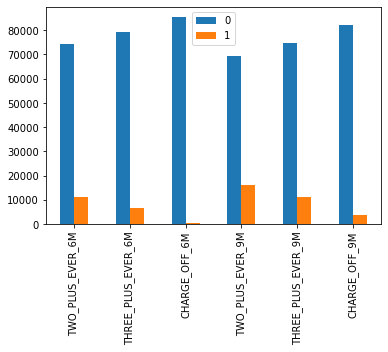

In [448]:
# check distribution of labelled variables
c_lst = ['TWO_PLUS_EVER_6M', 'THREE_PLUS_EVER_6M','CHARGE_OFF_6M', 'TWO_PLUS_EVER_9M', 'THREE_PLUS_EVER_9M','CHARGE_OFF_9M']
plt_df = df_cmap[c_lst]
plt_df.apply(pd.value_counts).T.plot.bar()

In [451]:
# exclude non-independent variables
non_ind_vars = ['PROG_SOL_NUMBER', 'VENDOR_ID', 'APPLICATION_DATE', 'ACCOUNT_OPEN_DATE', 'PROG_SOL_NUMBER0', 'FILE_NAME', 'DATA_SOURCE_ID', 'RECORD_SEQ_NO','CREATED_DATE', 'CREATED_BY', 'UPDATED_DATE', 'UPDATED_BY']
target_vars = ['TWO_PLUS_EVER_6M', 'THREE_PLUS_EVER_6M', 'CHARGE_OFF_6M', 'TWO_PLUS_EVER_9M', 'THREE_PLUS_EVER_9M', 'CHARGE_OFF_9M']
ind_var_df = df_train_new.drop(columns=non_ind_vars).drop(columns=target_vars)
ind_var_df

,WEB_APPS,FRAUD_CHARGEOFF,AMS3242,AMS3909,AMS3102,AMS3836,AMS3856,AMS3257,AMS3109,AMS3124,...,AMS3981,AMS3982,AMS3983,AMS3984,AMS3986,AMS3987,AMS3988,AMS3989,AMS3991,AMS3992
1,0,0,0.0,0.0,8.0,3200.0,6482.0,0.0,25.0,34.0,...,400.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0,0,0.0,1.0,20.0,7174.0,3574.0,0.0,46.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0,0,0.0,0.0,10.0,8333.0,3069.0,0.0,18.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,0,0,0.0,1.0,5.0,8571.0,8979.0,0.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,0,0,0.0,0.0,14.0,8400.0,7223.0,0.0,25.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195441,0,0,0.0,0.0,4.0,2000.0,2425.0,0.0,5.0,18.0,...,8000.0,2000.0,1667.0,0.0,0.0,2000.0,1667.0,0.0,0.0,2000.0
195443,0,0,0.0,0.0,2.0,1667.0,0.0,0.0,6.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195444,0,0,0.0,0.0,6.0,6667.0,4530.0,0.0,12.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195445,0,0,0.0,8.0,13.0,4286.0,2019.0,0.0,28.0,1.0,...,3929.0,3929.0,1607.0,4615.0,0.0,3214.0,1607.0,4615.0,0.0,3214.0


In [452]:
corr_df = ind_var_df.corr()
#fig, ax = plt.subplots(figsize=(24, 12))
#sns.heatmap(corr_df, annot=True, vmin=-1.0)
#plt.title('Correlation Heatmap')
#plt.show()

In [453]:
corr_df

,WEB_APPS,FRAUD_CHARGEOFF,AMS3242,AMS3909,AMS3102,AMS3836,AMS3856,AMS3257,AMS3109,AMS3124,...,AMS3981,AMS3982,AMS3983,AMS3984,AMS3986,AMS3987,AMS3988,AMS3989,AMS3991,AMS3992
WEB_APPS,1.000000,-0.016095,0.018473,0.065515,0.159317,0.002947,0.166464,0.028591,0.131009,-0.141714,...,0.121634,0.121325,0.052511,0.040865,0.016786,0.047574,0.055977,0.040782,0.018403,0.050442
FRAUD_CHARGEOFF,-0.016095,1.000000,-0.006212,-0.015664,0.008426,-0.011216,-0.033821,-0.007258,-0.001146,0.020850,...,-0.021544,-0.018932,-0.012259,-0.008932,-0.007522,-0.010568,-0.010853,-0.007767,-0.006623,-0.009462
AMS3242,0.018473,-0.006212,1.000000,0.043743,-0.020706,-0.032744,-0.003232,-0.014982,-0.021267,0.009478,...,0.054923,0.053642,0.052262,0.023709,0.109554,0.023226,0.058230,0.021797,0.124454,0.024218
AMS3909,0.065515,-0.015664,0.043743,1.000000,-0.036826,-0.088559,0.040883,-0.010038,-0.014260,-0.013088,...,0.240781,0.264594,0.050843,0.054713,0.005046,0.080956,0.056692,0.064552,0.002397,0.095716
AMS3102,0.159317,0.008426,-0.020706,-0.036826,1.000000,-0.201880,-0.057761,0.051926,0.846903,-0.212832,...,-0.037226,-0.041420,-0.021729,-0.005336,-0.016281,-0.024967,-0.020209,-0.007604,-0.014147,-0.025884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMS3987,0.047574,-0.010568,0.023226,0.080956,-0.024967,-0.254622,0.014630,0.003126,-0.028136,0.012283,...,0.478646,0.433405,0.769638,0.792060,0.127612,1.000000,0.687789,0.696524,0.130140,0.904235
AMS3988,0.055977,-0.010853,0.058230,0.056692,-0.020209,-0.221704,0.001427,-0.001891,-0.015010,-0.005846,...,0.334478,0.375688,0.929491,0.552445,0.457461,0.687789,1.000000,0.599830,0.512113,0.756847
AMS3989,0.040782,-0.007767,0.021797,0.064552,-0.007604,-0.206181,-0.002168,0.014305,0.001195,0.022499,...,0.329351,0.368019,0.566350,0.899052,0.114495,0.696524,0.599830,1.000000,0.120947,0.768574
AMS3991,0.018403,-0.006623,0.124454,0.002397,-0.014147,-0.075347,-0.012400,-0.013066,-0.013934,-0.014936,...,0.074740,0.083509,0.471402,0.115517,0.881570,0.130140,0.512113,0.120947,1.000000,0.136999


In [454]:
# We are not yet dropping any variables from the correlation matrix, as we are going to get more insights from model anlalysis.
upper_corr = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
upper_corr

,WEB_APPS,FRAUD_CHARGEOFF,AMS3242,AMS3909,AMS3102,AMS3836,AMS3856,AMS3257,AMS3109,AMS3124,...,AMS3981,AMS3982,AMS3983,AMS3984,AMS3986,AMS3987,AMS3988,AMS3989,AMS3991,AMS3992
WEB_APPS,NaN,-0.016095,0.018473,0.065515,0.159317,0.002947,0.166464,0.028591,0.131009,-0.141714,...,0.121634,0.121325,0.052511,0.040865,0.016786,0.047574,0.055977,0.040782,0.018403,0.050442
FRAUD_CHARGEOFF,NaN,NaN,-0.006212,-0.015664,0.008426,-0.011216,-0.033821,-0.007258,-0.001146,0.020850,...,-0.021544,-0.018932,-0.012259,-0.008932,-0.007522,-0.010568,-0.010853,-0.007767,-0.006623,-0.009462
AMS3242,NaN,NaN,NaN,0.043743,-0.020706,-0.032744,-0.003232,-0.014982,-0.021267,0.009478,...,0.054923,0.053642,0.052262,0.023709,0.109554,0.023226,0.058230,0.021797,0.124454,0.024218
AMS3909,NaN,NaN,NaN,NaN,-0.036826,-0.088559,0.040883,-0.010038,-0.014260,-0.013088,...,0.240781,0.264594,0.050843,0.054713,0.005046,0.080956,0.056692,0.064552,0.002397,0.095716
AMS3102,NaN,NaN,NaN,NaN,NaN,-0.201880,-0.057761,0.051926,0.846903,-0.212832,...,-0.037226,-0.041420,-0.021729,-0.005336,-0.016281,-0.024967,-0.020209,-0.007604,-0.014147,-0.025884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMS3987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.687789,0.696524,0.130140,0.904235
AMS3988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.599830,0.512113,0.756847
AMS3989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120947,0.768574
AMS3991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136999


In [455]:
# set correlation threshold to remove variables
corr_threshold = 0.8
corr_to_drop = [col for col in upper_corr.columns if any(np.abs(upper_corr[col])>corr_threshold)]
print(len(corr_to_drop))
corr_to_drop

172


['AMS3109',
 'AMS3104',
 'AMS3120',
 'AMS3134',
 'AMS3135',
 'AMS3137',
 'AMS3139',
 'AMS3148',
 'AMS3157',
 'AMS3178',
 'AMS3194',
 'AMS3224',
 'AMS3236',
 'AMS3237',
 'AMS3239',
 'AMS3246',
 'AMS3277',
 'AMS3297',
 'AMS3316',
 'AMS3327',
 'AMS3329',
 'AMS3330',
 'AMS3333',
 'AMS3336',
 'AMS3338',
 'AMS3340',
 'AMS3347',
 'AMS3349',
 'AMS3350',
 'AMS3352',
 'AMS3354',
 'AMS3355',
 'AMS3356',
 'AMS3358',
 'AMS3360',
 'AMS3366',
 'AMS3367',
 'AMS3368',
 'AMS3369',
 'AMS3370',
 'AMS3372',
 'AMS3374',
 'AMS3376',
 'AMS3386',
 'AMS3395',
 'AMS3404',
 'AMS3410',
 'AMS3415',
 'AMS3417',
 'AMS3424',
 'AMS3435',
 'AMS3448',
 'AMS3453',
 'AMS3471',
 'AMS3472',
 'AMS3474',
 'AMS3479',
 'AMS3480',
 'AMS3544',
 'AMS3555',
 'AMS3562',
 'AMS3573',
 'AMS3590',
 'AMS3601',
 'AMS3608',
 'AMS3612',
 'AMS3614',
 'AMS3616',
 'AMS3619',
 'AMS3623',
 'AMS3625',
 'AMS3627',
 'AMS3630',
 'AMS3634',
 'AMS3724',
 'AMS3746',
 'AMS3747',
 'AMS3748',
 'AMS3750',
 'AMS3751',
 'AMS3752',
 'AMS3754',
 'AMS3795',
 'AM

In [456]:
# create a look-up mechanism for checking
corr_to_drop_lkp = {}
for var in corr_to_drop:
    var_corr = corr_df[var][np.abs(corr_df[var])>corr_threshold]
    var_over_corr = list(var_corr.index[var_corr.apply(pd.notnull)])
    var_corr_lkp = [corr_df[var][v] for v in var_over_corr]
    corr_to_drop_lkp[var] = list(zip(var_over_corr,var_corr_lkp))

In [457]:
corr_to_drop_lkp

{'AMS3109': [('AMS3102', 0.8469026602779645),
  ('AMS3109', 1.0),
  ('AMS3104', 0.8109198533655922),
  ('AMS3178', 0.8712662788017899),
  ('AMS3376', 0.9614676213109649),
  ('AMS3751', 0.8026456867549573),
  ('AMS3754', 0.8050240810006271),
  ('AMS3966', 0.8113180728400433),
  ('AMS3967', 0.9726203006331571)],
 'AMS3104': [('AMS3109', 0.8109198533655922),
  ('AMS3104', 1.0),
  ('AMS3178', 0.9284159470229107)],
 'AMS3120': [('AMS3111', 0.8704119043969146), ('AMS3120', 1.0)],
 'AMS3134': [('AMS3133', 0.8898554462026441),
  ('AMS3134', 1.0),
  ('AMS3194', 0.8392298796834204)],
 'AMS3135': [('AMS3133', 0.8331710772338674),
  ('AMS3135', 1.0),
  ('AMS3194', 0.8863080336139653)],
 'AMS3137': [('AMS3146', 0.8358419421771421),
  ('AMS3137', 1.0),
  ('AMS3148', 0.8871956831523031),
  ('AMS3329', 0.9869295055859102),
  ('AMS3336', 0.8298310455428186),
  ('AMS3338', 0.9926928531758004),
  ('AMS3347', 0.8295547779970568),
  ('AMS3471', 0.9234843564296543),
  ('AMS3472', 0.999133228139961),
  ('AMS

In [458]:
# find common variables, keep common variables
common_var, common_val = zip(*corr_to_drop_lkp[list(corr_to_drop_lkp.keys())[0]])
for var in corr_to_drop_lkp:
    corr_var_val = corr_to_drop_lkp[var]
    corr_var, corr_val = zip(*corr_var_val)
    common_var = list(set(common_var).intersection(set(corr_var)))
common_var

[]

In [459]:
# find frequent variables, keep the most frequent variables
freq_var, freq_val = zip(*corr_to_drop_lkp[list(corr_to_drop_lkp.keys())[0]])
freq_var = list(freq_var)
for var in corr_to_drop_lkp:
    corr_var_val = corr_to_drop_lkp[var]
    corr_var, corr_val = zip(*corr_var_val)
    freq_var.extend(corr_var)
print(len(freq_var))
freq_var_set = set(freq_var)
print(len(freq_var_set))
freq = {var:freq_var.count(var) for var in freq_var_set}
freq = {k: v for k, v in sorted(freq.items(), key=lambda item: -item[1])}
freq_threshold = 10
freq_to_keep = [k for k,v in freq.items() if v>=10]
print(len(freq_to_keep))
freq_to_keep

1365
230
55


['AMS3754',
 'AMS3751',
 'AMS3893',
 'AMS3937',
 'AMS3347',
 'AMS3146',
 'AMS3336',
 'AMS3601',
 'AMS3329',
 'AMS3933',
 'AMS3886',
 'AMS3934',
 'AMS3752',
 'AMS3932',
 'AMS3747',
 'AMS3471',
 'AMS3137',
 'AMS3338',
 'AMS3887',
 'AMS3885',
 'AMS3472',
 'AMS3935',
 'AMS3888',
 'AMS3748',
 'AMS3921',
 'AMS3594',
 'AMS3936',
 'AMS3920',
 'AMS3922',
 'AMS3139',
 'AMS3330',
 'AMS3889',
 'AMS3874',
 'AMS3340',
 'AMS3942',
 'AMS3873',
 'AMS3875',
 'AMS3983',
 'AMS3967',
 'AMS3871',
 'AMS3870',
 'AMS3376',
 'AMS3895',
 'AMS3872',
 'AMS3943',
 'AMS3360',
 'AMS3966',
 'AMS3919',
 'AMS3896',
 'AMS3592',
 'AMS3918',
 'AMS3894',
 'AMS3148',
 'AMS3327',
 'AMS3370']

In [460]:
# this number of variables to keep are from the original corr_to_drop variables, the rest comes from the correlated variables
len(list(set(corr_to_drop).intersection(set(freq_to_keep))))

52

In [461]:
corr_to_drop_final = [var for var in corr_to_drop if var not in common_var and var not in freq_to_keep]
len(corr_to_drop_final)

120

In [462]:
df_train_corr = df_train_new.drop(columns=non_ind_vars).drop(columns=corr_to_drop_final)
df_train_corr.shape

(85740, 190)

In [463]:
# Run Lasso regression to further shrink feature size

In [464]:
#Get X variables
X_train_corr = df_train_corr.drop(columns=target_vars)
#Get all 6 target variables
y1_var, y2_var, y3_var, y4_var, y5_var, y6_var = df_train_corr[target_vars].columns
y_vars = [y1_var, y2_var, y3_var, y4_var, y5_var, y6_var]
ys = {var:df_train_corr[var] for var in y_vars}

In [465]:
{k:v for k,v in zip(X_train_corr.isnull().sum().index, list(X_train_corr.isnull().sum()))}

{'WEB_APPS': 0,
 'FRAUD_CHARGEOFF': 0,
 'AMS3242': 0,
 'AMS3909': 0,
 'AMS3102': 0,
 'AMS3836': 0,
 'AMS3856': 0,
 'AMS3257': 0,
 'AMS3124': 0,
 'AMS3146': 0,
 'AMS3100': 0,
 'AMS3101': 0,
 'AMS3105': 0,
 'AMS3111': 0,
 'AMS3113': 0,
 'AMS3116': 0,
 'AMS3122': 0,
 'AMS3127': 0,
 'AMS3133': 0,
 'AMS3136': 0,
 'AMS3137': 0,
 'AMS3139': 0,
 'AMS3142': 0,
 'AMS3148': 0,
 'AMS3159': 0,
 'AMS3168': 0,
 'AMS3175': 0,
 'AMS3176': 0,
 'AMS3177': 0,
 'AMS3192': 0,
 'AMS3193': 0,
 'AMS3208': 0,
 'AMS3215': 0,
 'AMS3217': 0,
 'AMS3235': 0,
 'AMS3266': 0,
 'AMS3268': 0,
 'AMS3270': 0,
 'AMS3273': 0,
 'AMS3286': 0,
 'AMS3288': 0,
 'AMS3290': 0,
 'AMS3293': 0,
 'AMS3307': 0,
 'AMS3309': 0,
 'AMS3312': 0,
 'AMS3318': 0,
 'AMS3320': 0,
 'AMS3323': 0,
 'AMS3327': 0,
 'AMS3329': 0,
 'AMS3330': 0,
 'AMS3336': 0,
 'AMS3338': 0,
 'AMS3340': 0,
 'AMS3347': 0,
 'AMS3360': 0,
 'AMS3361': 0,
 'AMS3362': 0,
 'AMS3364': 0,
 'AMS3370': 0,
 'AMS3376': 0,
 'AMS3379': 0,
 'AMS3380': 0,
 'AMS3383': 0,
 'AMS3388': 0,
 

In [466]:
#Impute missing values
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy='constant')
#imp.fit(X_train_corr.values)
#X_train_corr_impute = imp.transform(X_train_corr)

In [467]:
X_train_corr_impute = X_train_corr

In [468]:
#X_train_corr_impute

In [469]:
feature_list = list(X_train_corr_impute.columns)
feature_list

['WEB_APPS',
 'FRAUD_CHARGEOFF',
 'AMS3242',
 'AMS3909',
 'AMS3102',
 'AMS3836',
 'AMS3856',
 'AMS3257',
 'AMS3124',
 'AMS3146',
 'AMS3100',
 'AMS3101',
 'AMS3105',
 'AMS3111',
 'AMS3113',
 'AMS3116',
 'AMS3122',
 'AMS3127',
 'AMS3133',
 'AMS3136',
 'AMS3137',
 'AMS3139',
 'AMS3142',
 'AMS3148',
 'AMS3159',
 'AMS3168',
 'AMS3175',
 'AMS3176',
 'AMS3177',
 'AMS3192',
 'AMS3193',
 'AMS3208',
 'AMS3215',
 'AMS3217',
 'AMS3235',
 'AMS3266',
 'AMS3268',
 'AMS3270',
 'AMS3273',
 'AMS3286',
 'AMS3288',
 'AMS3290',
 'AMS3293',
 'AMS3307',
 'AMS3309',
 'AMS3312',
 'AMS3318',
 'AMS3320',
 'AMS3323',
 'AMS3327',
 'AMS3329',
 'AMS3330',
 'AMS3336',
 'AMS3338',
 'AMS3340',
 'AMS3347',
 'AMS3360',
 'AMS3361',
 'AMS3362',
 'AMS3364',
 'AMS3370',
 'AMS3376',
 'AMS3379',
 'AMS3380',
 'AMS3383',
 'AMS3388',
 'AMS3389',
 'AMS3392',
 'AMS3397',
 'AMS3398',
 'AMS3401',
 'AMS3406',
 'AMS3407',
 'AMS3413',
 'AMS3420',
 'AMS3426',
 'AMS3428',
 'AMS3431',
 'AMS3437',
 'AMS3439',
 'AMS3442',
 'AMS3446',
 'AMS34

In [470]:
#Split data into 70/30 sets
X = X_train_corr_impute
y = ys[y5_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [471]:
#Standardization
#scaler = StandardScaler().fit(X_train) 
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [472]:
#Build Lasso regressor
lasso_reg = LassoCV(cv=5, random_state=0, max_iter=1000)
lasso_reg.fit(X_train, y_train)

LassoCV(cv=5, random_state=0)

In [473]:
lasso_reg.alpha_

0.8756049484781347

In [474]:
# Set best alpha
lasso_best = Lasso(alpha=lasso_reg.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.8756049484781347)

In [475]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 4.8
R squared test set 4.11


In [476]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.10629845984194136

In [477]:
#Show model coefficients and names:
print(sorted(list(zip(lasso_best.coef_, X_train_corr)), key=lambda x:-np.abs(x[0]))[:39])

[(-3.4476691511776273e-05, 'AMS3743'), (2.3971845658842636e-05, 'AMS3843'), (-1.2093665770240098e-05, 'AMS3869'), (1.0017979260648332e-05, 'AMS3856'), (-8.710762766587154e-06, 'AMS3864'), (8.041882311538094e-06, 'AMS3827'), (7.931364024703761e-06, 'AMS3829'), (-5.865850183770129e-06, 'AMS3837'), (4.660257128929235e-06, 'AMS3811'), (-4.647478127552295e-06, 'AMS3841'), (-4.294193490620133e-06, 'AMS3865'), (3.944391825414672e-06, 'AMS3845'), (-3.4916505540076868e-06, 'AMS3235'), (-3.3039841734959146e-06, 'AMS3862'), (-2.9085535925988673e-06, 'AMS3900'), (2.7611351731707946e-06, 'AMS3832'), (2.3949720444962484e-06, 'AMS3914'), (-2.1289006286380392e-06, 'AMS3839'), (-2.0376018301653635e-06, 'AMS3984'), (-1.9595341718471905e-06, 'AMS3840'), (1.888318841688868e-06, 'AMS3835'), (-1.2126814216229124e-06, 'AMS3838'), (1.0628069812381796e-06, 'AMS3833'), (1.0567484027217614e-06, 'AMS3986'), (9.93848264660731e-07, 'AMS3810'), (-9.092386885836714e-07, 'AMS3896'), (-4.811089688426252e-07, 'AMS3895')

In [478]:
lasso_coef_features = sorted(list(zip(lasso_best.coef_, X_train_corr)), key=lambda x:-np.abs(x[0]))
lasso_coef_features

[(-3.4476691511776273e-05, 'AMS3743'),
 (2.3971845658842636e-05, 'AMS3843'),
 (-1.2093665770240098e-05, 'AMS3869'),
 (1.0017979260648332e-05, 'AMS3856'),
 (-8.710762766587154e-06, 'AMS3864'),
 (8.041882311538094e-06, 'AMS3827'),
 (7.931364024703761e-06, 'AMS3829'),
 (-5.865850183770129e-06, 'AMS3837'),
 (4.660257128929235e-06, 'AMS3811'),
 (-4.647478127552295e-06, 'AMS3841'),
 (-4.294193490620133e-06, 'AMS3865'),
 (3.944391825414672e-06, 'AMS3845'),
 (-3.4916505540076868e-06, 'AMS3235'),
 (-3.3039841734959146e-06, 'AMS3862'),
 (-2.9085535925988673e-06, 'AMS3900'),
 (2.7611351731707946e-06, 'AMS3832'),
 (2.3949720444962484e-06, 'AMS3914'),
 (-2.1289006286380392e-06, 'AMS3839'),
 (-2.0376018301653635e-06, 'AMS3984'),
 (-1.9595341718471905e-06, 'AMS3840'),
 (1.888318841688868e-06, 'AMS3835'),
 (-1.2126814216229124e-06, 'AMS3838'),
 (1.0628069812381796e-06, 'AMS3833'),
 (1.0567484027217614e-06, 'AMS3986'),
 (9.93848264660731e-07, 'AMS3810'),
 (-9.092386885836714e-07, 'AMS3896'),
 (-4.81108

In [479]:
lasso_features = [f for c,f in lasso_coef_features if np.abs(c)>0]
lasso_features

['AMS3743',
 'AMS3843',
 'AMS3869',
 'AMS3856',
 'AMS3864',
 'AMS3827',
 'AMS3829',
 'AMS3837',
 'AMS3811',
 'AMS3841',
 'AMS3865',
 'AMS3845',
 'AMS3235',
 'AMS3862',
 'AMS3900',
 'AMS3832',
 'AMS3914',
 'AMS3839',
 'AMS3984',
 'AMS3840',
 'AMS3835',
 'AMS3838',
 'AMS3833',
 'AMS3986',
 'AMS3810',
 'AMS3896',
 'AMS3895',
 'AMS3863',
 'AMS3831',
 'AMS3159',
 'AMS3168',
 'AMS3208',
 'AMS3242']

In [480]:
X = X_train_corr_impute[lasso_features]
y = ys[y5_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [481]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [482]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.23 degrees.


In [483]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -inf %.


In [484]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: WEB_APPS             Importance: 0.08
Variable: AMS3909              Importance: 0.08
Variable: AMS3192              Importance: 0.07
Variable: AMS3208              Importance: 0.07
Variable: FRAUD_CHARGEOFF      Importance: 0.05
Variable: AMS3102              Importance: 0.05
Variable: AMS3836              Importance: 0.05
Variable: AMS3116              Importance: 0.05
Variable: AMS3193              Importance: 0.05
Variable: AMS3124              Importance: 0.04
Variable: AMS3856              Importance: 0.03
Variable: AMS3257              Importance: 0.03
Variable: AMS3101              Importance: 0.03
Variable: AMS3136              Importance: 0.03
Variable: AMS3137              Importance: 0.03
Variable: AMS3159              Importance: 0.03
Variable: AMS3146              Importance: 0.02
Variable: AMS3100              Importance: 0.02
Variable: AMS3113              Importance: 0.02
Variable: AMS3127              Importance: 0.02
Variable: AMS3139              Importanc

In [487]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [492]:
scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean cross-validation score: 0.87
K-fold CV average score: 0.87


In [497]:
ypred = xgbc.predict(X_test)
cm = confusion_matrix(y_test,ypred)
print(cm)

[[22272   184]
 [ 3170    96]]
